<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/02_traditional_rag_vs_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the difference between Traditional RAG (Retrieval Augmented Generation) and Agentic RAG.

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 202 (delta 62), reused 30 (delta 30), pack-reused 108 (from 1)
Receiving objects: 100% (202/202), 3.10 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (104/104), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 M

## Load credentials from .env

In [ ]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize OpenAI LLM and Embeddings via langchain_openai
We will use OpenAI **GPT models** and **text-embedding-3-small** for the embedding model.

In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Initialize OpenAI LLM using LangChain
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model_name="gpt-4.1",
                 temperature=0)

# Initialize OpenAI Embedding model using LangChain
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY,
                              model="text-embedding-3-small")

## Initialize Langfuse Handler for Tracing

In [ ]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client

os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

langfuse_handler = CallbackHandler()

Langfuse client is authenticated and ready!


# Indexing

## Load data

Load the data from the `page_data.pkl` file. This contains all the crawled DHS 2025 pages in a markdown format.


In [ ]:
import pickle
with open("data/page_data.pkl", "rb") as f:
    pages = pickle.load(f)

## Create langchain documents

Convert the loaded data into LangChain `Document` objects.


In [ ]:
from langchain_core.documents import Document

documents = [] # Initialize an empty list to store LangChain Document objects.
for page in pages: # Iterate through each page in the 'pages' list.
    # Create a Document object for each page.
    # 'page_content' is set to the content of the page, and 'metadata' includes the page's URL.
    doc = Document(page_content=page['content'], metadata={'url': page['url']})
    documents.append(doc) # Add the created Document object to the 'documents' list.

print(f"Created {len(documents)} LangChain documents.") # Print the total number of documents created.

Created 155 LangChain documents.


In [ ]:
pages[0]

{'url': 'https://www.analyticsvidhya.com/datahacksummit/',
 'content': "# The AI Trinity\n\n## Powering the Future\n\n### Generative | Agentic | Responsible\n\n## India's Most Futuristic AI Conference\n\n### August 20-23, 2025  • The Leela Bhartiya City Bengaluru \n\nSend WhatsApp Updates\n\nDownload Agenda\n\nYour browser does not support the video tag. \n\n## 1200+\n\n### Attendees\n\n## 80+\n\n### AI Talks\n\n## 50+\n\n### Hack Sessions\n\n## 10+\n\n### Workshops\n\n## Hands-on AI Workshops\n\n### [Mastering Intelligent Agents: A Deep Dive into Agentic AI Dipanjan Sarkar - Analytics Vidhya  ](/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)\n\n[ 🔥 Most Trending Mastering Real-World Multi-Agent Systems Alessandro Romano - Kuehne+Nagel  ](/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)\n\n[ Almost Sold Out Mastering Real-World Agentic AI Applications with AG2 (AutoGen) Hrushikesh Dokala - 

## Create Custom Metadata Chunks

* 1 webpage or URL = 1 Chunk
* Enhance the metadata of each chunk by including a custom MD tag from the DHS webpages to easily classify the chunks as 'Session' or 'Speaker' or 'Workshop' and the likes

In [ ]:
from urllib.parse import urlparse

def extract_section_from_url(url: str) -> str:
    """
    Extracts the main section name from a given URL.

    Args:
        url: The URL string from which to extract the section.

    Returns:
        A string representing the main section of the URL,
        or "Overview" if no specific section is identified.
    """
    path = urlparse(url).path
    parts = [p for p in path.strip("/").split("/") if p]

    if "datahacksummit-2025" in parts:
        parts.remove("datahacksummit-2025")

    if parts:
        return parts[0].replace("-", " ").title()
    else:
        return "Overview"

for item in documents:
  section = extract_section_from_url(item.metadata["url"])
  item.metadata['section'] = section

In [ ]:
for doc in documents:
    metadata_str = "\n\nMetadata:\n\n"
    for key, value in doc.metadata.items():
        metadata_str += f", {key}: {value} "
    doc.page_content += metadata_str

In [ ]:
documents[76]

Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit-2025/speakers/anshu-kumar-2', 'section': 'Speakers'}, page_content='# Anshu Kumar [ ](https://www.linkedin.com/in/anshu19/)\n\nLead Data Scientist\n\nAnshu Kumar is the Lead Data Scientist at Target India. He holds an M.Tech in Computer Science & Engineering from IIT Madras. With a career spanning roles at Walmart, VMware, and various startups, Anshu has designed and deployed machine learning solutions in e-commerce (search and recommendations) and social media marketing. His recent work focuses on utilizing LLMs and Vision LLMs to enhance product search. Additionally, Anshu is a published author with Packt and enjoys writing on Medium.\n\nRead more\n\n##  Hack Sessions\n\nCollaborative Multi-Agent Framework for Robust SEO Content Generation\n\nAnshu Kumar\n\nLead Data Scientist\n\nExplore a modular and resilient agent framework designed for SEO content generation. Discover how multiple specialized agents can wor

In [ ]:
documents[130]

Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit-2025/sessions/deploying-genai-safely-strategies-for-trustworthy-llms', 'section': 'Sessions'}, page_content='# Deploying GenAI Safely: Strategies for Trustworthy LLMs\n\nHack Session\n\n## About\n\nThis talk will explore the critical aspects of securing GenAI applications, beginning with the unique security challenges they introduce. We will examine key vulnerabilities in depth, including manipulative prompt injection attacks, jailbreaks designed to bypass safety controls, risks related to sensitive data leakage, the generation of inaccurate hallucinations, and the dangers of improper model output handling. The agenda focuses on providing actionable insights through effective mitigation strategies, methods for early vulnerability identification, and adherence to proven best practices, ultimately aiming to equip attendees with the knowledge to build secure, resilient, and trustworthy LLM-powered systems while mini

In [ ]:
from collections import Counter

urls = [doc.metadata['url'] for doc in documents]
url_counts = Counter(urls)

duplicate_urls = [url for url, count in url_counts.items() if count > 1]

if duplicate_urls:
    print("Duplicate URLs found:")
    for url in duplicate_urls:
        print(url)
else:
    print("No duplicate URLs found.")

No duplicate URLs found.


## Create vector store

Create a vector store from the document chunks and the initialized embeddings.
We save this vector store in a persistent directory so that we can use it in future.


In [ ]:
from langchain_community.vectorstores import Chroma

persist_directory = os.getcwd() +'/vectorstore/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

155


# RAG Retrieval Pipeline

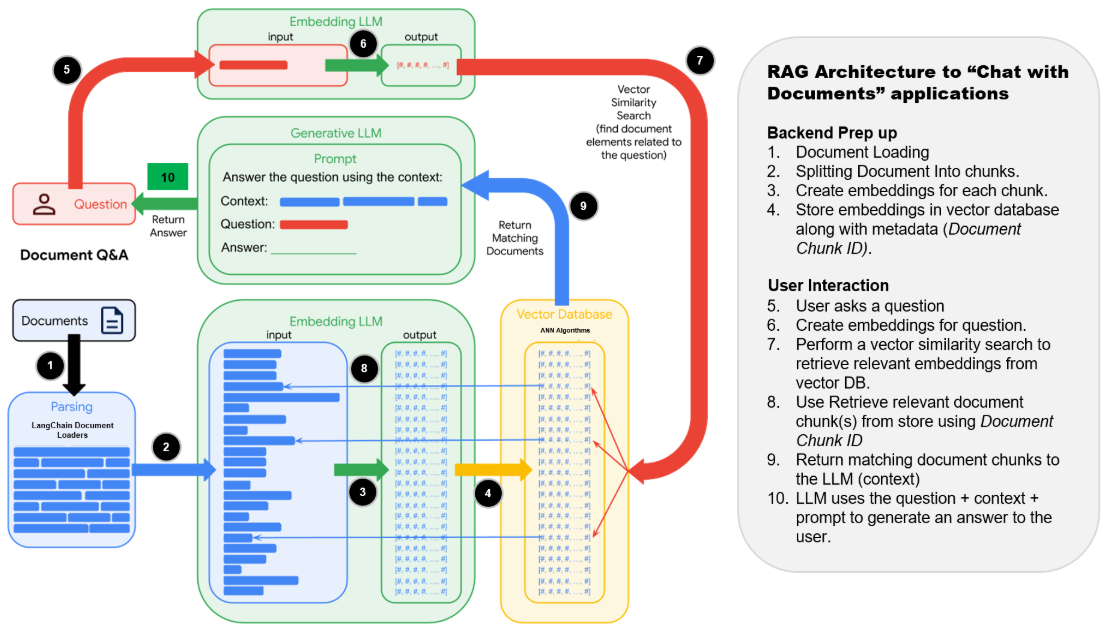

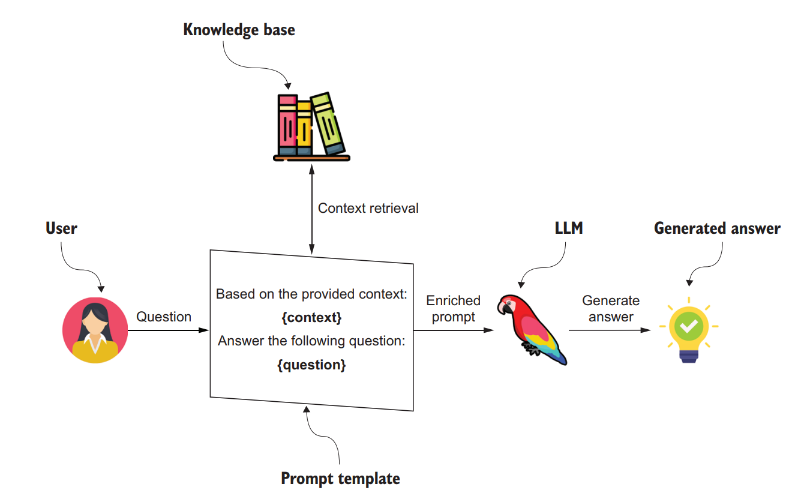

## Retrieval

Once the vector database is populated, you can define it as the retriever component, which fetches the additional context based on the semantic similarity between the user query and the embedded chunks.

To implement hybrid search with ChromaDB in LangChain, we combine vector similarity search and traditional keyword searches (like BM25) using an ensemble technique. Although ChromaDB itself does not have built-in hybrid search, LangChain allows you to blend different retrievers to achieve this effect.

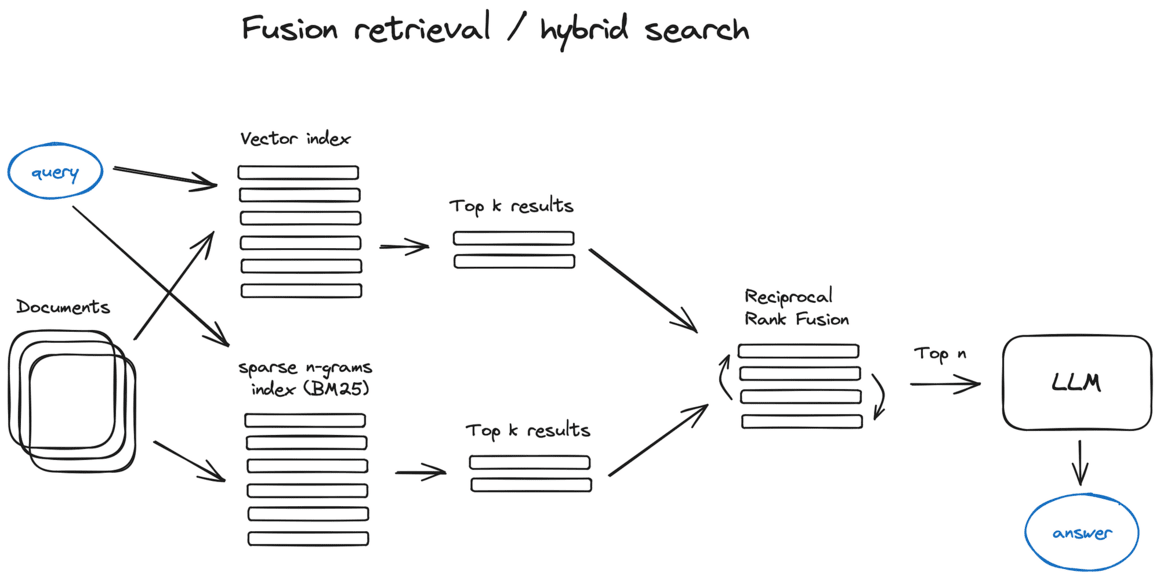

In [ ]:
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

#Initialize ChromaDB Vector Store (Dense/Semantic Retriever)
similarity_search_retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 5})

#Prepare BM25 Retriever (Keyword/Sparse Retriever)
bm25_retriever = BM25Retriever.from_documents(documents=documents, k=5)


#Create an Ensemble Retriever:Combine both the semantic (vector) and keyword (BM25) retrievers using EnsembleRetriever.
ensemble_retriever = EnsembleRetriever(
    retrievers=[similarity_search_retriever, bm25_retriever],
    weights=[0.5, 0.5]
)

## Augmentation
Next, to augment the prompt with the additional context, you need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below.

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Avoid using generic phrases like "Provide context" or "as per context.

#### Answering and Formatting Instructions

1. **Markdown Formatting (MANDATORY):**
   - All responses must be formatted in Markdown.
   - Use bold text for all the headers and subheaders.
   - Use bullets, tables wherever applicable.
   - Do not use plain text or paragraphs without Markdown structure.
   - Ensure that you use hyphens (-) for list bullets. For sub-bullets, indent using 2 spaces (not tabs). Ensure proper nesting and consistent formatting.

2. **Citations Must (MANDATORY):**
    - Citations must be immediately placed after the relevant content. Use the Metadata to Cite relevant URLs as meaningful hyperlinks wherever applicable.
    - Do not place citations at the end or in a separate references section. They should appear directly after the statement being referenced. **Place inline citations immediately after the relevant content**
    - Do not include tool names or retriever names in citations.

Question: {input}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

## Generation
Finally, you can build a chain for the RAG pipeline, chaining together the retriever, the prompt template and the LLM. Once the RAG chain is defined, you can invoke it.

* `create_stuff_documents_chain(llm, prompt)`: This creates a chain that takes a list of documents and a prompt, formats the documents into the prompt, and then passes the prompt to the language model (llm) to generate an answer.

* `create_retrieval_chain(ensemble_retriever, combine_docs_chain)`: This creates the main RAG chain. It takes the ensemble_retriever (which retrieves relevant documents based on the input question) and the combine_docs_chain (which formats the retrieved documents and generates an answer using the LLM). When this chain is invoked with a question, it first uses the retriever to get relevant documents and then passes those documents to the combine_docs_chain to generate the final answer.

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a chain for passing a list of Documents to a model.
combine_docs_chain = create_stuff_documents_chain(llm, prompt)

# Create a retrieval chain
rag_chain = create_retrieval_chain(ensemble_retriever, combine_docs_chain)

## Test Traditional RAG

Test the traditional RAG implementation with a sample query.

In [ ]:
bm25_retriever.invoke("arun")

[Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit/#schedule', 'section': 'Datahacksummit'}, page_content='| Day   | Date       | Venue   | Session Type   | Start Time   | End Time   | Topic                                                                       | Speaker                                              |\n|:------|:-----------|:--------|:---------------|:-------------|:-----------|:----------------------------------------------------------------------------|:-----------------------------------------------------|\n| Day 1 | 2025-08-20 | ChatGPT | Opening Remark | 10:00        | 10:20      | Opening Remarks                                                             | Kunal Jain                                           |\n| Day 1 | 2025-08-20 | ChatGPT | Keynote        | 10:20        | 11:20      | Responsible AI in Medical Imaging – A Case Study                            | Dr. Geetha Manjunath                                 |\n| Day 1 | 2025-08-20 

In [ ]:
from IPython.display import Markdown

question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
response = rag_chain.invoke({"input": question},config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Most Frequently Covered Topics at DHS 2025**

- **Agentic AI & AI Agents**
  - Core focus across workshops and sessions, including building, deploying, and operationalizing agentic AI systems, multi-agent orchestration, and real-world applications using frameworks like LangChain, LangGraph, CrewAI, and AutoGen ([source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai), [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)).
- **Large Language Models (LLMs) & Generative AI**
  - Topics include LLM training, fine-tuning, RAG (Retrieval-Augmented Generation), and integrating LLMs with agentic workflows ([source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/from-theory-to-practice-training-llms-reinforcement-learning-and-ai)).
- **Agentic System Design Patterns, Observability, and Governance**
  - Emphasis on architecture, memory management, monitoring, evaluation, risk mitigation, and governance for reliable, production-ready agentic AI systems ([source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-effective-agentic-ai-systems-lessons-from-the-field), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/detecting-and-mitigating-risks-in-agentic-aino-title)).

In [ ]:
question = "List down all the sessions or workshops which uses LangGraph?"
response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Sessions and Workshops Using LangGraph**

- **Hack Sessions**
  - Mastering Agentic Workflows with LangGraph: Focuses on building graph-based LLM workflows, agent architectures, reflexion loops, and agentic RAG using LangGraph [details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals).
  - Agentic Knowledge Augmented Generation: The Next Leap After RAG: Explores Agentic KAG using Knowledge Graphs, Neo4j, Chroma DB, ReAct Agents, and includes LangGraph for agent orchestration [details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag).

- **Workshops**
  - Agentic RAG Workshop: From Fundamentals to Real-World Implementations: Covers Agentic RAG with LangGraph for agent orchestration and complex workflow management [details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title).
  - LLMOps – Productionalizing Real-World Applications with LLMs and Agents: Includes a dedicated module on Multi-Agent Workflows with LangGraph [details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2).
  - AgentOps: Building and Deploying AI Agents: Features hands-on modules for building agents and multi-agent systems using LangGraph [details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentops-building-and-deploying-ai-agents).

In [ ]:
question = "Which sessions covers Neo4j?"
response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Session Covering Neo4j**

- The session titled **"Agentic Knowledge Augmented Generation: The Next Leap After RAG"** specifically covers building a knowledge graph using Neo4j as the backend for graph traversal and reasoning, and demonstrates an end-to-end Agentic KAG pipeline with Neo4j integration [Agentic Knowledge Augmented Generation: The Next Leap After RAG](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag).
- This session provides hands-on experience in constructing knowledge graphs, integrating Neo4j, and leveraging it for advanced agentic workflows.

In [ ]:
question = "Who is Arun?"
response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Who is Arun?**

- **Arun Prakash Asokan** is an award-winning AI thought leader and Associate Director of Data Science, recognized as a Top Gen AI Leader 2024 by Analytics Vidhya and honored globally for his AI innovations.
- With nearly 17 years of experience, he leads global AI programs, pioneering enterprise-wide GenAI solutions, reusable accelerators, and AI security frameworks, and has mentored thousands through talks and workshops worldwide.
- Arun holds advanced degrees from BITS Pilani and ISB Hyderabad, and is known for democratizing AI, delivering 75+ GenAI talks in the past two years, and driving measurable business impact across multiple domains [Read more](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2).

In [ ]:
question = "Who is Arun Prakash? How many deliveries is he doing?"
response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Who is Arun Prakash?**

- Arun Prakash Asokan is an award-winning AI thought leader and Associate Director of Data Science, recognized as a Top Gen AI Leader 2024 by Analytics Vidhya, with nearly 17 years of experience in AI, including leading global AI programs and pioneering enterprise AI solutions across multiple domains [Read more](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2).

**How many deliveries is he doing?**

- There is no information available regarding Arun Prakash Asokan doing any deliveries or the number of deliveries he is doing [Read more](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2).

In [ ]:
question = "Which workshop does not deal with AI agents??"
response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

Markdown(response["answer"])

**Workshop That Does NOT Deal with AI Agents**

- **Mastering LLMs: Training, Fine-Tuning, and Best Practices** is the only listed workshop that does not focus on AI agents; it centers on large language models (LLMs), their training, fine-tuning, and best practices, without mention of agentic systems or agent workflows [[source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2)].  
- All other workshops, such as "Mastering Intelligent Agents," "AgentOps," "Mastering Real-World Agentic AI Applications with AG2," and "Agentic RAG Workshop," explicitly cover AI agents or agentic AI systems.

## Test Agentic RAG

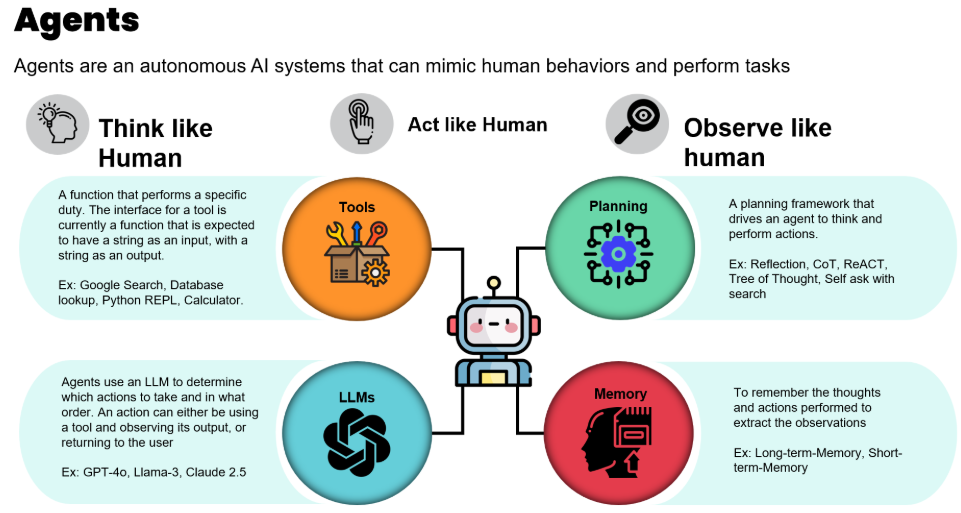

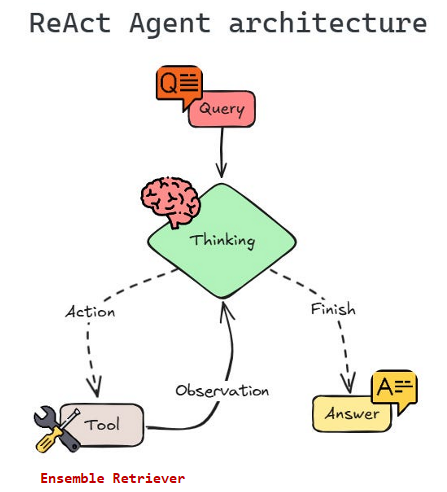

In [ ]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    AIMessagePromptTemplate,
    PromptTemplate,
)

In [ ]:
# Let's make a tool out of the Ensemble Retriever
from langchain.tools.retriever import create_retriever_tool

AV_retriever_tool = create_retriever_tool(retriever=ensemble_retriever,
                            name = 'AV_DHS_Retriever',
                            description="Use this tool to answer questions related to related to Analytics Vidhya's DHS 2025")
tools = [AV_retriever_tool]


In [ ]:
# Get the ReAct prompt
prompt = '''
You are an intelligent agent tasked with answering questions by reasoning step-by-step and using tools when necessary. Follow the format precisely.

#### Answering and Formatting Instructions

1. **Markdown Formatting (MANDATORY):**
   - All responses must be formatted in Markdown.
   - Use bold text for all the headers and subheaders.
   - Use bullets, tables wherever applicable.
   - Do not use plain text or paragraphs without Markdown structure.
   - Ensure that you use hyphens (-) for list bullets. For sub-bullets, indent using 2 spaces (not tabs). Ensure proper nesting and consistent formatting.

2. **Citations Must (MANDATORY):**
    - Citations must be immediately placed after the relevant content. Cite relevant URLs as meaningful hyperlinks wherever applicable.
    - Do not place citations at the end or in a separate references section. They should appear directly after the statement being referenced. **Place inline citations immediately after the relevant content**
    - Do not include tool names or retriever names in citations.

Answer the following questions as best you can in a clear markdown format. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: [tool name] - should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''


In [ ]:
# Create the ReAct agent
def get_react_agent(llm, tools, system_prompt, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="conversation_history", optional=True),
            HumanMessagePromptTemplate(
                prompt=PromptTemplate(input_variables=["input"], template="{input}")
            ),
            AIMessagePromptTemplate(
                prompt=PromptTemplate(
                    input_variables=["agent_scratchpad"], template="{agent_scratchpad}"
                )
            ),
        ]
    )
    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=verbose,
        stream_runnable=True,
        handle_parsing_errors=True,
        max_iterations=5,
        return_intermediate_steps=True,
    )

generate_agent = get_react_agent(
        llm,
        tools,
        prompt,
        verbose=False,
    )


In [ ]:
question = "Who is Arun?"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])

**

**Who is Arun?**

- **Full Name:** Arun Prakash Asokan
- **Current Role:** Associate Director Data Science
- **Recognition & Awards:**
  - Top Gen AI Leader 2024 by Analytics Vidhya
  - Scholar of Excellence from ISB Hyderabad
  - Grand Global Winner of the Tableau International Contest
- **Education:**
  - Master's in Computer Science Engineering from BITS Pilani
  - B.Tech. in Computer Science & Engineering
  - Advanced Management Program from Indian School of Business, Hyderabad
- **Experience:**
  - Nearly 17 years in AI, including 7 years at Novartis
  - Leads global AI programs for enterprise-wide adoption of AI and GenAI solutions
  - Known for bridging business vision with technical execution
- **Key Achievements:**
  - Pioneered GenAI accelerators reducing development time by up to 80%
  - Developed enterprise-grade AI security frameworks
  - Created award-winning AI platforms for anomaly detection and risk mitigation
- **Community & Thought Leadership:**
  - Spent a decade democratizing AI through talks, keynotes, hack sessions, and mentoring
  - Delivered several hundred talks, including 75+ on GenAI in the past two years at ISB, IIMB, IIITH, Analytics Vidhya, and other global forums
- **DHS 2025 Involvement:**
  - Conducting the "Agentic RAG Workshop: From Fundamentals to Real-World Implementations"
  - Leading the session "Agentic Knowledge Augmented Generation: The Next Leap After RAG"

For more details, see his [speaker profile on Analytics Vidhya](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2).

In [ ]:
question = "Who is Arun Prakash? How many deliveries is he doing?"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])

**Who is Arun Prakash?**

- **Arun Prakash Asokan** is the Associate Director of Data Science at Novartis.
- He is an award-winning AI thought leader, recognized as a **Top Gen AI Leader 2024** by Analytics Vidhya, a **Scholar of Excellence** from ISB Hyderabad, and the **Grand Global Winner** of the Tableau International Contest.
- Arun has nearly 17 years of experience in AI, with expertise in enterprise AI adoption, GenAI solutions, and building AI platforms for anomaly detection and risk mitigation.
- He is known for his community contributions, having mentored thousands of AI enthusiasts and delivered several hundred talks, including 75+ on GenAI in the past two years at top institutions and forums.
- He is a strategic AI translator, bridging business vision with technical execution, and has pioneered reusable GenAI accelerators and enterprise-grade AI security frameworks.
- Arun is a featured speaker and workshop instructor at DataHack Summit 2025, leading sessions on Agentic RAG and Agentic Knowledge Augmented Generation.
  - [Speaker Profile](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2)

**How many deliveries is he doing?**

- At DataHack Summit 2025, Arun Prakash is delivering:
  - **One full-day workshop**:  
    - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**  
      - Date: 23 August 2025  
      - Duration: 09:30AM - 05:30PM (8 hours, including breaks)  
      - [Workshop Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)
  - **One hack session**:  
    - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**  
      - Duration: 12:00PM - 12:50PM (50 minutes)  
      - [Session Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

- **Total Deliveries:**  
  - **2 sessions** at DHS 2025:  
    - 1 workshop  
    - 1 hack session

**Summary Table**

| Delivery Type | Title                                                                 | Duration         | Link                                                                 |
|---------------|-----------------------------------------------------------------------|------------------|----------------------------------------------------------------------|
| Workshop      | Agentic RAG Workshop: From Fundamentals to Real-World Implementations | 8 hours          | [Workshop Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title) |
| Hack Session  | Agentic Knowledge Augmented Generation: The Next Leap After RAG       | 50 minutes       | [Session Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)          |

**References:**  
- [Arun Prakash Asokan - Speaker Profile](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2)
- [Agentic RAG Workshop](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)
- [Agentic Knowledge Augmented Generation Hack Session](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

In [ ]:
question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: To answer this, I need to find an overview or summary of the most common topics across all sessions and workshops at DHS 2025. I will search for a list or analysis of session topics.
Action: AV_DHS_Retriever
Action Input: most frequently covered topics across all sessions and workshops at DHS 2025# Joshua Starmer [ ](https://www.linkedin.com/in/joshua-starmer-phd/)

Founder and CEO

Dr. Joshua Starmer, the Founder and CEO of Statsquest and previously working as lead AI educator at Lightning AI, is a distinguished figure in data science and is set to illuminate the stage at DataHack Summit 2025. With a Ph.D. in Biomathematics and an illustrious career spanning academia and industry, Dr. Starmer brings a wealth of expertise to the forefront of analytics. With a passion for translating complex concepts into actionable insights, Dr. Starmer's dynamic presentations promise to empower audiences with cutting-edge knowledge and strategic perspec

Thought: I now know the final answer.
Final Answer: 

**Most Frequently Covered Topics at DHS 2025**

---

- **Agentic AI & AI Agents**
  - Building, deploying, and operationalizing intelligent agents is a central theme, with multiple workshops and sessions dedicated to Agentic AI, multi-agent systems, and frameworks like LangChain, CrewAI, AutoGen, and LangGraph.
  - Topics include agent architecture, orchestration, memory management, observability, and real-world deployment challenges.
  - Example sessions: "Mastering Intelligent Agents: A Deep Dive into Agentic AI", "AgentOps: Building and Deploying AI Agents", "Building Effective Agentic AI Systems: Lessons from the Field", "AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai), [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentops-building-and-deploying

**Most Frequently Covered Topics at DHS 2025**

---

- **Agentic AI & AI Agents**
  - Building, deploying, and operationalizing intelligent agents is a central theme, with multiple workshops and sessions dedicated to Agentic AI, multi-agent systems, and frameworks like LangChain, CrewAI, AutoGen, and LangGraph.
  - Topics include agent architecture, orchestration, memory management, observability, and real-world deployment challenges.
  - Example sessions: "Mastering Intelligent Agents: A Deep Dive into Agentic AI", "AgentOps: Building and Deploying AI Agents", "Building Effective Agentic AI Systems: Lessons from the Field", "AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai), [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentops-building-and-deploying-ai-agents), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-effective-agentic-ai-systems-lessons-from-the-field)

- **Large Language Models (LLMs) & Generative AI**
  - Training, fine-tuning, prompt engineering, and advanced applications of LLMs are widely discussed.
  - Workshops and sessions cover foundational models (BERT, GPT-2, LLaMA3, Gemma, OpenAI), PEFT, LoRA, RLHF, and operationalizing LLMs in production.
  - Example sessions: "From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents", "Mastering LLMs: Training, Fine-Tuning, and Best Practices"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/from-theory-to-practice-training-llms-reinforcement-learning-and-ai), [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2)

- **Retrieval-Augmented Generation (RAG) & Agentic RAG**
  - Multiple sessions focus on enhancing RAG pipelines with agentic reasoning, multi-modal retrieval, and business applications.
  - Example sessions: "Agentic RAG Workshop: From Fundamentals to Real-World Implementations", "Agentic Knowledge Augmented Generation: The Next Leap After RAG"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

- **Multi-Agent Systems & Orchestration**
  - Hands-on workshops and panels on orchestrating multiple agents, agent collaboration, and real-world workflow automation.
  - Example: "Mastering Real-World Multi-Agent Systems", "Automate Everything: Building Agentic AI Workflows with No-Code Tools"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/automate-everything-building-agentic-ai-workflows-with-no-code-tools)

- **AI Governance, Risk, and Observability**
  - Sessions on risk mitigation, agent alignment, monitoring, and evaluation of AI systems.
  - Example: "Detecting and Mitigating Risks in Agentic AI", "Observability (Monitoring & Evaluation) for Agentic AI Systems"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/detecting-and-mitigating-risks-in-agentic-aino-title), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-effective-agentic-ai-systems-lessons-from-the-field)

- **Emerging Trends: Reasoning Models, Voice Agents, and Creative AI**
  - Reasoning-focused LLMs, AI voice agents, and creative AI agents for media and design are also prominent.
  - Example: "Scaling Test-time Inference Compute & Advent of Reasoning Models", "AI Voice Agent: The Future of Human-Computer Interaction", "Creative AI Agents: Open Tools for Collaborative Media Creation"  
  [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/scaling-test-time-inference-compute-advent-of-reasoning-models), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/ai-voice-agentfuture-of-human-computer-interaction), [source](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/creative-ai-agents-open-tools-for-collaborative-media-creation)

---

**Summary Table**

| Topic Area                        | Example Sessions/Workshops                                                                                 |
|------------------------------------|----------------------------------------------------------------------------------------------------------|
| Agentic AI & AI Agents            | Mastering Intelligent Agents, AgentOps, Building Effective Agentic AI Systems, Agent Frameworks Panel     |
| LLMs & Generative AI              | From Beginner to Expert: LLMs, Mastering LLMs, Quantifying Confidence in Neural Networks                  |
| RAG & Agentic RAG                 | Agentic RAG Workshop, Agentic Knowledge Augmented Generation                                             |
| Multi-Agent Systems & Orchestration| Mastering Real-World Multi-Agent Systems, Automate Everything with No-Code Tools                         |
| AI Governance & Observability      | Detecting and Mitigating Risks, Observability for Agentic AI Systems                                     |
| Reasoning Models & Creative AI     | Scaling Test-time Inference Compute, AI Voice Agent, Creative AI Agents                                  |

---

**Conclusion:**  
The most frequently covered topics at DHS 2025 are Agentic AI and AI agents, LLMs and Generative AI, RAG and Agentic RAG, multi-agent orchestration, AI governance and observability, and emerging trends like reasoning models, voice agents, and creative AI. These themes are reflected across both workshops and sessions, indicating a strong focus on practical, scalable, and responsible AI systems for real-world applications  
([source](https://www.analyticsvidhya.com/datahacksummit-2025/)).

In [ ]:
question = "List down all the sessions or workshops which uses LangGraph??"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: I need to find all sessions or workshops in DHS 2025 that mention the use of LangGraph.
Action: AV_DHS_Retriever
Action Input: sessions or workshops using LangGraph# Mastering Agentic Workflows with LangGraph

Hack Session

## About

This session on LangGraph is on building graph-based LLM workflows. We will explore agent architectures with memory and tools, implement reflexion loops for self-improvement, and build intelligent systems that combine retrieval and reasoning through agentic RAG. We'll also cover tracing and experiment tracking  


## Key Takeaways:

  * Building graph-based Agentic workflows using LangGraph
  * Creating intelligent agents with tools, memory, and decision logic
  * Implementing reflexion and error-handling loops
  * Developing a context-aware Agentic RAG
  * Tracking and tracing your experiments



## Speaker

[ ](/datahacksummit-2025/speakers/sanathraj-narayan-2)

#  [Sanathraj Narayan](/datahacksummit-2025/

Thought: I now know the final answer.

Final Answer:

**Sessions and Workshops at DHS 2025 that Use LangGraph**

---

- **Workshops**

  - **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
    - Focus: Building Agentic AI & Agentic RAG Systems using LangChain, LangGraph, and CrewAI.
    - Instructor: Dipanjan Sarkar
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)

  - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
    - Focus: Building Agentic RAG applications with LangChain and LangGraph for agent orchestration and workflow management.
    - Instructor: Arun Prakash Asokan
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

  - **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
    - Focus: Orchestrating multi-agent workflows u

**Sessions and Workshops at DHS 2025 that Use LangGraph**

---

- **Workshops**

  - **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
    - Focus: Building Agentic AI & Agentic RAG Systems using LangChain, LangGraph, and CrewAI.
    - Instructor: Dipanjan Sarkar
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)

  - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
    - Focus: Building Agentic RAG applications with LangChain and LangGraph for agent orchestration and workflow management.
    - Instructor: Arun Prakash Asokan
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

  - **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
    - Focus: Orchestrating multi-agent workflows using LangGraph, building RAG pipelines, and deploying GenAI systems.
    - Instructor: Kartik Nighania
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)

  - **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
    - Focus: Building multimodal Telegram agents, managing workflows with LangGraph, and integrating memory, vision, and speech.
    - Instructor: Miguel Otero Pedrido
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)

---

- **Hack Sessions**

  - **Mastering Agentic Workflows with LangGraph**
    - Focus: Building graph-based LLM workflows, agent architectures, reflexion loops, and agentic RAG using LangGraph.
    - Speaker: Sanathraj Narayan
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)

  - **Building Effective Agentic AI Systems: Lessons from the Field**
    - Focus: Architecting, optimizing, and monitoring Agentic AI Systems with hands-on code demos using LangGraph.
    - Speaker: Dipanjan Sarkar
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-effective-agentic-ai-systems-lessons-from-the-field)

  - **Beyond PoCs: Building Real-World Agentic Systems**
    - Focus: Fundamentals of agents, Agentic RAG, and productionizing agentic systems using LangGraph.
    - Speaker: Miguel Otero Pedrido
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)

---

- **Hack Panel**

  - **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
    - Focus: Live demos and panel discussion comparing AutoGen, CrewAI, and LangGraph for building multi-agent helpdesk AI assistants.
    - Panelists: Dipanjan Sarkar, Praneeth Paikray, Mayank Aggarwal, Sanathraj Narayan
    - [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)

---

**Summary Table**

| Type         | Session/Workshop Title                                                                 | Link                                                                                                                        |
|--------------|---------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| Workshop     | Mastering Intelligent Agents: A Deep Dive into Agentic AI                             | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai) |
| Workshop     | Agentic RAG Workshop: From Fundamentals to Real-World Implementations                 | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title) |
| Workshop     | LLMOps – Productionalizing Real-World Applications with LLMs and Agents               | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)          |
| Workshop     | Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language         | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)        |
| Hack Session | Mastering Agentic Workflows with LangGraph                                            | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)    |
| Hack Session | Building Effective Agentic AI Systems: Lessons from the Field                         | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-effective-agentic-ai-systems-lessons-from-the-field)             |
| Hack Session | Beyond PoCs: Building Real-World Agentic Systems                                      | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)                          |
| Hack Panel   | AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks                        | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)            |

---

**All of the above sessions and workshops explicitly mention the use of LangGraph for building, orchestrating, or comparing agentic workflows and systems.**

In [ ]:
question = "List down all the sessions by Arun??"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])

**Sessions by Arun Prakash Asokan at DataHack Summit 2025**

---

### 1. Agentic RAG Workshop: From Fundamentals to Real-World Implementations
- **Type:** Workshop (Full Day)
- **Date & Time:** 09:30AM - 05:30PM
- **Venue:** La Marvella, 2nd Block, Jayanagar, Bengaluru
- **Description:**  
  Deep dive into Agentic RAG (Retrieval-Augmented Generation) combining LLM-based agents with retrieval techniques. Hands-on with Google Colab, Azure Document Intelligence, Chroma Vector DB, LangChain, LangGraph, and Langfuse.  
  [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

---

### 2. Agentic Knowledge Augmented Generation: The Next Leap After RAG
- **Type:** Hack Session
- **Date & Time:** Day 1 (August 20, 2025), 12:00PM - 12:50PM
- **Venue:** Gemini Track
- **Description:**  
  Live hack session on Agentic Knowledge Augmented Generation (Agentic KAG) using Knowledge Graphs, Graph Databases (Neo4j), Chroma DB, and ReAct Agents.  
  [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

---

**Summary Table**

| Session Title                                                                 | Type      | Date & Time                | Venue/Track         |
|-------------------------------------------------------------------------------|-----------|----------------------------|---------------------|
| Agentic RAG Workshop: From Fundamentals to Real-World Implementations         | Workshop  | 09:30AM - 05:30PM (TBA)    | La Marvella         |
| Agentic Knowledge Augmented Generation: The Next Leap After RAG               | Hack Session | 20 Aug 2025, 12:00-12:50PM | Gemini              |

---

**References:**  
- [Arun Prakash Asokan Speaker Profile](https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2)  
- [Agentic RAG Workshop Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)  
- [Agentic Knowledge Augmented Generation Session](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)  
- [DHS 2025 Schedule](https://www.analyticsvidhya.com/datahacksummit/#schedule)

In [ ]:
question = "Which sessions covers Neo4j??"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Question: Which sessions covers Neo4j??
Thought: I need to find out which sessions in DHS 2025 mention or cover Neo4j.
Action: AV_DHS_Retriever
Action Input: sessions covering Neo4j| Day   | Date       | Venue   | Session Type   | Start Time   | End Time   | Topic                                                                       | Speaker                                              |
|:------|:-----------|:--------|:---------------|:-------------|:-----------|:----------------------------------------------------------------------------|:-----------------------------------------------------|
| Day 1 | 2025-08-20 | ChatGPT | Opening Remark | 10:00        | 10:20      | Opening Remarks                                                             | Kunal Jain                                           |
| Day 1 | 2025-08-20 | ChatGPT | Keynote        | 10:20        | 11:20      | Responsible AI in Medical Imaging – A Case Study                    

Thought: I now know the final answer.
Final Answer:

**Sessions Covering Neo4j at DHS 2025**

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - **Type:** Hack Session
  - **Speaker:** Arun Prakash Asokan
  - **Description:** This session will demonstrate how to build a knowledge graph from scratch using Neo4j as the backend for graph traversal and reasoning. The session will also compare traditional RAG, Agentic RAG, and Agentic KAG, and show how to build an end-to-end Agentic KAG pipeline with Neo4j.
  - **Key Takeaways:**
    - Build a knowledge graph from unstructured data.
    - Create an end-to-end Agentic KAG pipeline with Neo4j.
    - Use Chroma DB for RAG baselines and ReAct agents for dynamic decision-making.
  - **Direct mention of Neo4j:** "Use Neo4j Graph Database as the backend to power graph traversal and reasoning."
  - **[Session Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-

**Sessions Covering Neo4j at DHS 2025**

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - **Type:** Hack Session
  - **Speaker:** Arun Prakash Asokan
  - **Description:** This session will demonstrate how to build a knowledge graph from scratch using Neo4j as the backend for graph traversal and reasoning. The session will also compare traditional RAG, Agentic RAG, and Agentic KAG, and show how to build an end-to-end Agentic KAG pipeline with Neo4j.
  - **Key Takeaways:**
    - Build a knowledge graph from unstructured data.
    - Create an end-to-end Agentic KAG pipeline with Neo4j.
    - Use Chroma DB for RAG baselines and ReAct agents for dynamic decision-making.
  - **Direct mention of Neo4j:** "Use Neo4j Graph Database as the backend to power graph traversal and reasoning."
  - **[Session Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)**

**Summary Table**

| Session Name                                                        | Speaker                | Neo4j Usage Description                                                                                 | Link                                                                                      |
|---------------------------------------------------------------------|------------------------|---------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| Agentic Knowledge Augmented Generation: The Next Leap After RAG     | Arun Prakash Asokan    | Build knowledge graphs and Agentic KAG pipelines using Neo4j for graph traversal and reasoning           | [Session Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag) |

- No other session in the DHS 2025 schedule explicitly mentions Neo4j as a core technology or topic.  
- For more details and the full schedule, visit the [DHS 2025 Schedule](https://www.analyticsvidhya.com/datahacksummit/#schedule).

In [ ]:
question = "Which sessions covers knowledge graphs??"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])

**Sessions Covering Knowledge Graphs at DHS 2025**

- **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - **Type:** Hack Session
  - **Speaker:** Arun Prakash Asokan
  - **Description:** 
    - Focuses on building Knowledge Graphs from scratch using real-world datasets.
    - Covers the use of Neo4j Graph Database for graph traversal and reasoning.
    - Explores the integration of Knowledge Graphs, Graph Databases, and AI Agents to enable LLMs to generate knowledge-rich, contextual outputs.
    - Includes hands-on experience in building knowledge graphs from unstructured data and constructing end-to-end Agentic KAG pipelines.
  - **Link:** [Agentic Knowledge Augmented Generation: The Next Leap After RAG](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

- **Mastering Agentic Workflows with LangGraph**
  - **Type:** Hack Session
  - **Speaker:** Sanathraj Narayan
  - **Description:** 
    - Focuses on building graph-based LLM workflows.
    - Explores agent architectures, memory, tools, and the development of context-aware Agentic RAG (Retrieval-Augmented Generation) using graph-based approaches.
  - **Link:** [Mastering Agentic Workflows with LangGraph](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - **Type:** Workshop
  - **Speaker:** Arun Prakash Asokan
  - **Description:** 
    - Deep dive into Agentic RAG, including the use of LangGraph for agent orchestration and complex workflow management.
    - Covers multi-modal retrieval and reasoning, which may involve knowledge graph concepts.
  - **Link:** [Agentic RAG Workshop: From Fundamentals to Real-World Implementations](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

**Summary Table**

| Session Title                                                        | Type        | Speaker                | Knowledge Graph Focus | Link                                                                                  |
|---------------------------------------------------------------------|-------------|------------------------|----------------------|---------------------------------------------------------------------------------------|
| Agentic Knowledge Augmented Generation: The Next Leap After RAG      | Hack Session| Arun Prakash Asokan    | Yes                  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag) |
| Mastering Agentic Workflows with LangGraph                           | Hack Session| Sanathraj Narayan      | Yes (graph workflows)| [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals) |
| Agentic RAG Workshop: From Fundamentals to Real-World Implementations| Workshop    | Arun Prakash Asokan    | Partial (LangGraph)  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title) |

These sessions are the primary ones at DHS 2025 that cover knowledge graphs, their construction, and their integration with AI and LLM workflows.

In [ ]:
question = "Which workshop does not deal with AI agents??"
answer = generate_agent.invoke(
            {
                "input": question,
            },
            config={"callbacks": [langfuse_handler]}
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: I need to identify which workshops are listed and determine which one does not focus on AI agents. I should look up the list of workshops and their descriptions.
Action: AV_DHS_Retriever
Action Input: List of workshops and their topics at DHS 2025# Joshua Starmer [ ](https://www.linkedin.com/in/joshua-starmer-phd/)

Founder and CEO

Dr. Joshua Starmer, the Founder and CEO of Statsquest and previously working as lead AI educator at Lightning AI, is a distinguished figure in data science and is set to illuminate the stage at DataHack Summit 2025. With a Ph.D. in Biomathematics and an illustrious career spanning academia and industry, Dr. Starmer brings a wealth of expertise to the forefront of analytics. With a passion for translating complex concepts into actionable insights, Dr. Starmer's dynamic presentations promise to empower audiences with cutting-edge knowledge and strategic perspectives. Engage with Dr. Starmer at DataHack Summit t

**Thought:**  
I have identified the main workshops at DHS 2025. Most of them explicitly mention "AI agents," "Agentic AI," or "AgentOps" in their titles or descriptions. I need to check each workshop's content to see if any do not focus on AI agents.

**Workshops Identified:**
- From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents (focuses on AI agents)
- Mastering Intelligent Agents: A Deep Dive into Agentic AI (focuses on AI agents)
- AgentOps: Building and Deploying AI Agents (focuses on AI agents)
- Mastering LLMs: Training, Fine-Tuning, and Best Practices

Now, I will check the description of "Mastering LLMs: Training, Fine-Tuning, and Best Practices" to see if it is about AI agents or not.

**Key points from "Mastering LLMs: Training, Fine-Tuning, and Best Practices":**
- Focuses on LLMs (BERT, GPT2, LLaMA3, Gemma, OpenAI models)
- Covers language modeling, transformer architectures, prompt engineering, RAGs, RLHF, and tool-calling through MCP
- Only the la

**The workshop that does not deal with AI agents is:**

- **Mastering LLMs: Training, Fine-Tuning, and Best Practices**  
  [Workshop Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/mastering-llms-training-fine-tuning-and-best-practices-2)

All other workshops are primarily focused on AI agents or Agentic AI systems.